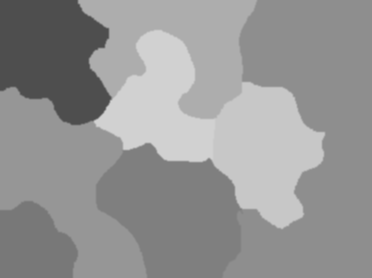

In [36]:
import cv2 
import numpy as np
import argparse
from google.colab.patches import cv2_imshow


# Read the original image
img = cv2.imread('colors.png',flags=0)  
# Blur the image for better edge detection
img_blur = cv2.GaussianBlur(img,(3,3), sigmaX=0, sigmaY=0) 
cv2_imshow(img_blur)

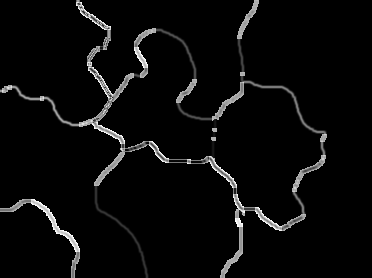

In [37]:
#Gradient calculation

from scipy import ndimage

def sobel_filters(img):
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
    
    Ix = ndimage.filters.convolve(img, Kx)
    Iy = ndimage.filters.convolve(img, Ky)
    
    G = np.hypot(Ix, Iy)
    G = G / G.max() * 255
    theta = np.arctan2(Iy, Ix)
    cv2_imshow(G)
    return (G, theta)

G=sobel_filters(img_blur)

In [38]:
img_blur.shape

(278, 372)

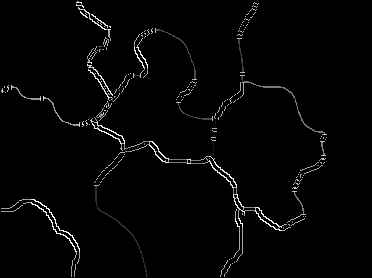

In [39]:
#Non maxima suppression

def non_max_suppression(img, D):
    M, N = img.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = D * 180. / np.pi
    angle[angle < 0] += 180

    
    for i in range(1,M-1):
        for j in range(1,N-1):
            try:
                q = 255
                r = 255
                
               #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
                #angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                #angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
                #angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]

                if (img[i,j] >= q) and (img[i,j] >= r):
                    Z[i,j] = img[i,j]
                else:
                    Z[i,j] = 0

            except IndexError as e:
                pass
    cv2_imshow(Z)
    return Z

Z=non_max_suppression(G[0],G[1])

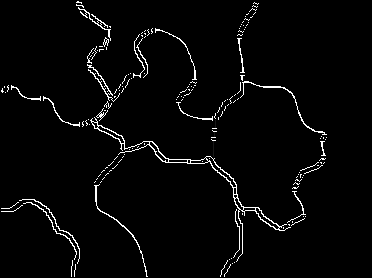

In [40]:
#double threshold

def threshold(img, lowThresholdRatio=0.02, highThresholdRatio=0.09):
    
    highThreshold = img.max() * highThresholdRatio;
    lowThreshold = highThresholdRatio * lowThresholdRatio;
    
    M, N = img.shape
    res = np.zeros((M,N), dtype=np.int32)
    
    weak = np.int32(25)
    strong = np.int32(255)
    
    strong_i, strong_j = np.where(img >= highThreshold)
    zeros_i, zeros_j = np.where(img < lowThreshold)
    
    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))
    
    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak
    
    cv2_imshow(res)
    
    return (res, weak, strong)

DT=threshold(Z)

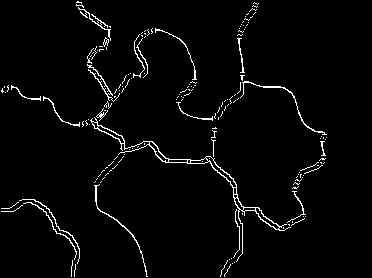

In [48]:
#Hysteresis

def hysteresis(img, weak, strong=255):
    M, N = img.shape  
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i,j] == weak):
                try:
                    if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                        or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                        or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                        img[i, j] = strong
                    else:
                        img[i, j] = 0
                except IndexError as e:
                    pass
    
    cv2_imshow(img)
    return img


final=hysteresis(DT[0],DT[1])

In [47]:
import cv2
cv2.imwrite("color_edge_detected", final)

error: ignored